# Fine-tuning Pre-trained Model for Perturbation Prediction

In [1]:
import argparse
from pathlib import Path
import gc
import json
import warnings
from typing import Tuple
import traceback
# Third-party library imports
import numpy as np
import torch
import itertools
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader, SequentialSampler
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Domain-specific imports
import scanpy as sc
import anndata as ad

# Custom library imports
from scgpt.data_collator import DataCollator
from scgpt.model import TransformerModel
from scgpt.tokenizer import GeneVocab
from scgpt.utils import load_pretrained

import scanpy as sc
import pandas as pd


from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import copy

from sklearn.utils.class_weight import compute_class_weight

import umap
import matplotlib.pyplot as plt
# Create a legend with custom handles
from matplotlib.lines import Line2D

/homefolder/talb/miniconda3/envs/p310cuda_2025/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/homefolder/talb/miniconda3/envs/p310cuda_2025/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/homefolder/talb/miniconda3/envs/p310cuda_2025/lib/python3.10/site-packages/torchtext-0.17.0a0+1d4ce73-py3.10-linux-x86_64.egg/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/homefolder/talb/miniconda3/envs/p310cuda_2025/lib/python3.10/site-packages/torchtext-0.17.0a0+1d4c

### Variables

In [2]:
max_length = 1800
batch_size = 128
device = "cuda"

### Paths

In [3]:
disease_dataset_path = ""
model_path = ""

### Functions

In [4]:
def plot_umap(positive_class, negative_class, cell_types, emb, desc):
    # Assuming emb is a numpy array or a similar matrix-like structure with dimensions (n_cells, n_features)
    # Perform UMAP on the embeddings
    reducer = umap.UMAP()
    embedding_umap = reducer.fit_transform(emb)
    
    # Define colors for the plot
    color_map = {
        positive_class: 'red',
        negative_class: 'blue',
    }
    
    # Extract the labels and map them to colors
    colors = [color_map.get(cell_type, 'grey') for cell_type in cell_types]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=colors, s=10, alpha=0.8)  # s is the size of the points
    
    # Add titles and labels
    plt.title(desc)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    
    
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=positive_class, markersize=10, markerfacecolor='red'),
        Line2D([0], [0], marker='o', color='w', label=negative_class, markersize=10, markerfacecolor='blue'),
        Line2D([0], [0], marker='o', color='w', label='Other', markersize=10, markerfacecolor='grey')
    ]
    
    plt.legend(handles=legend_elements)
    plt.show()



### Handle datasets

In [1]:
import scanpy as sc

disease_adata = sc.read_h5ad(r"C:\Users\maorb\Classes\Compugen\scGPT-niche\data\base_dataset.h5ad")
colon_index = disease_adata.obs.reset_index().query("tissue=='colon'").index.to_list()
colon_adata = disease_adata[colon_index, :]


## `EDA`

### Initial look


In [26]:
disease_adata.shape

(97788, 27289)

In [104]:
colon_adata

View of AnnData object with n_obs × n_vars = 27758 × 27289
    obs: 'biosample_id', 'n_genes', 'n_counts', 'Type', 'donor_id', 'Layer', 'Celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'age group', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'Celltype_colors', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_umap'

In [ ]:
## Number of duplicated rows
print(colon_adata.obs.duplicated().sum())

## Number of duplicated genes in the data
print("Number of duplicated genes:", colon_adata.var.duplicated(subset=['feature_name']).sum())

## Number of duplicated cell names in the data
print("Number of duplicated cells:", colon_adata.obs.index.duplicated().sum())

## Max and Min expressed genes over all cells
max_expression_value = colon_adata.X.max()
print("Max and Min expressed:", max_expression_value)

## Number of donors in the data
print("Number of donors:", len(colon_adata.obs.donor_id.unique()))
print("\n")
## Number of cell types in the data
print("Cell Types in the data: \n", colon_adata.obs.cell_type.value_counts())
print("\n")
## Value counts of layers:
print("Value counts of layers: \n", colon_adata.obs.Layer.value_counts())
print("\n")
## Value counts of cell types in each layer:
print("Primary data or no: \n", colon_adata.obs.is_primary_data.value_counts())

## Age group
print("Age group: \n", colon_adata.obs["age group"].value_counts())

## Sex
print("Sex: \n", colon_adata.obs["sex"].value_counts())


0
Number of duplicated genes: 0
Number of duplicated cells: 0
Max and Min expressed: 11.21
Number of donors: 7


Cell typesin the datra: 
 cell_type
enterocyte              14288
stem cell                6223
goblet cell              4479
epithelial cell          2331
enteroendocrine cell      189
brush cell                147
paneth cell               101
Name: count, dtype: int64


Value counts of layers: 
 Layer
N    25520
E     2189
L       49
Name: count, dtype: int64


Primary data or no: 
 is_primary_data
True     25520
False     2238
Name: count, dtype: int64
Age group: 
 age group
30-34    10929
70-74     9098
60-64     4061
50-54      751
25-29      681
Name: count, dtype: int64
Sex: 
 sex
male      20778
female     6980
Name: count, dtype: int64


In [53]:
colon_adata.var['feature_name'][:20]

ENSG00000228463    ENSG00000228463.10
ENSG00000237094    ENSG00000237094.13
ENSG00000228327     ENSG00000228327.6
ENSG00000237491             LINC01409
ENSG00000177757                FAM87B
ENSG00000225880             LINC00115
ENSG00000230368                FAM41C
ENSG00000223764             LINC02593
ENSG00000187634                SAMD11
ENSG00000188976                 NOC2L
ENSG00000187961                KLHL17
ENSG00000187583               PLEKHN1
ENSG00000272512     ENSG00000272512.1
ENSG00000188290                  HES4
ENSG00000187608                 ISG15
ENSG00000188157                  AGRN
ENSG00000237330                RNF223
ENSG00000131591              C1orf159
ENSG00000223823             LINC01342
ENSG00000272141     ENSG00000272141.1
Name: feature_name, dtype: category
Categories (27289, object): ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', ..., 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3']

In [40]:
# Convert to DataFrame with gene names as columns
import pandas as pd

# Get the first 10 cells and first 20 genes
subset_data = colon_adata.X[:10, :20]
gene_names = colon_adata.var['feature_name'][:20]
cell_ids = colon_adata.obs.index[:10]

# Create a DataFrame
expression_df = pd.DataFrame(
    subset_data.toarray() if hasattr(subset_data, 'toarray') else subset_data,
    index=cell_ids,
    columns=gene_names
)

# Display the DataFrame
print(expression_df)


feature_name                 ENSG00000228463.10  ENSG00000237094.13  \
cell_id                                                               
H197396_N1-GCTTGAAGTCATGCCG                1.58                 0.0   
H197396_N1-AGGGAGTCACCTTGTC                0.00                 0.0   
H197396_N1-CATATTCAGGGAGTAA                0.00                 0.0   
H197396_N1-CGCTTCAAGGCTACGA                0.00                 0.0   
H197396_N1-CGGAGTCGTGAGTGAC                1.85                 0.0   
H197396_N1-GCAGCCAAGGCTCATT                0.00                 0.0   
H197396_N1-TGGCCAGAGCTCCTCT                0.00                 0.0   
H197396_N1-AGAATAGGTGTCAATC                0.00                 0.0   
H197396_N1-GAACCTATCATACGGT                0.00                 0.0   
H197396_N1-ATAGACCAGTACGACG                0.00                 0.0   

feature_name                 ENSG00000228327.6  LINC01409  FAM87B  LINC00115  \
cell_id                                                            

### Most Expressed Genes

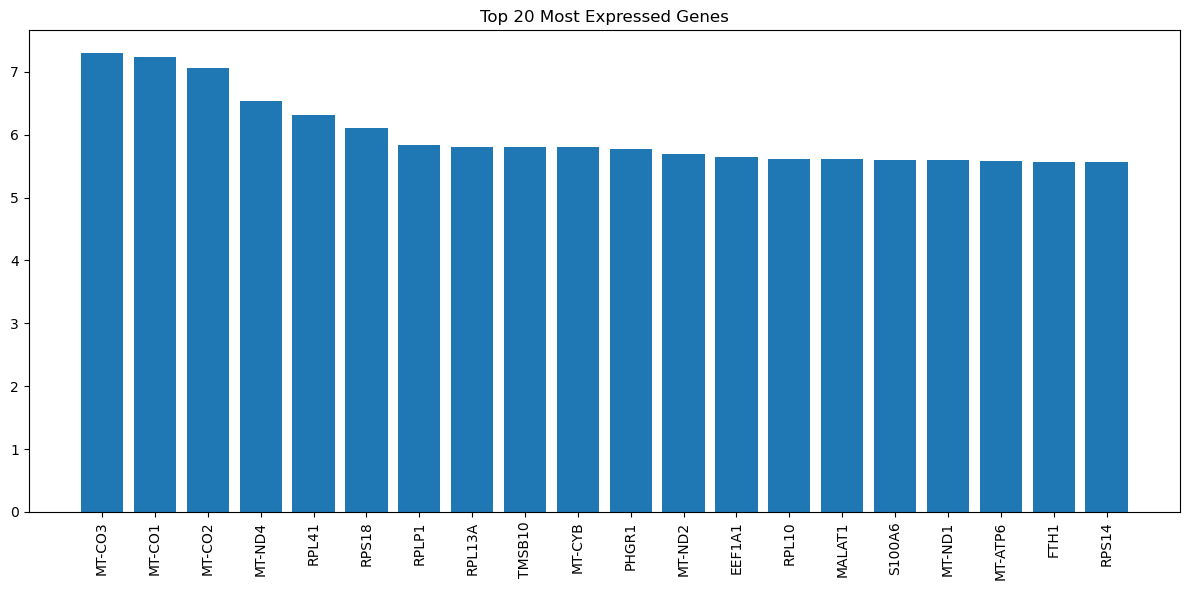

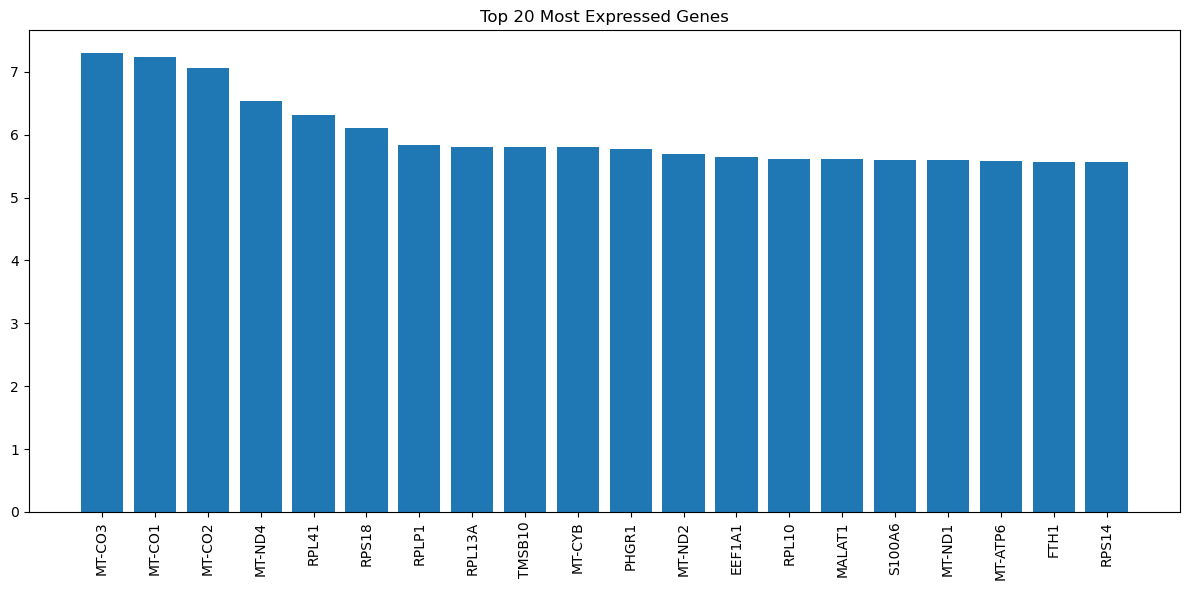

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_most_expressed_genes(adata, n_genes=20):
    """
    Find the most highly expressed genes in the dataset.
    
    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing gene expression data
    n_genes : int
        Number of top genes to return
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with gene names and their mean expression values
    """
    # Calculate mean expression for each gene across all cells
    if isinstance(adata.X, np.ndarray):
        mean_expr = adata.X.mean(axis=0)
    else:
        # For sparse matrices
        mean_expr = np.array(adata.X.mean(axis=0)).flatten()
    
    # Create a DataFrame with gene names and mean expression
    gene_expr_df = pd.DataFrame({
        'gene': adata.var['feature_name'],
        'mean_expression': mean_expr
    })
    
    # Sort by mean expression in descending order
    sorted_genes = gene_expr_df.sort_values('mean_expression', ascending=False)
    # Get top n genes
    top_genes = sorted_genes.head(n_genes)
    # Faster alternative using plain matplotlib
    fig = plt.figure(figsize=(12, 6))
    plt.bar(top_genes['gene'], top_genes['mean_expression'])
    plt.xticks(rotation=90)
    plt.title('Top 20 Most Expressed Genes')
    plt.tight_layout()
    return fig

    


# Usage
plot_most_expressed_genes(colon_adata, n_genes=20)





In [ ]:
# Convert to DataFrame with gene names as columns
import pandas as pd

# Get the first 10 cells and first 20 genes
subset_data = colon_adata.X[:10, :20]
gene_names = colon_adata.var['feature_name'][:20]
cell_ids = colon_adata.obs.index[:10]

# Create a DataFrame
expression_df = pd.DataFrame(
    subset_data.toarray() if hasattr(subset_data, 'toarray') else subset_data,
    index=cell_ids,
    columns=gene_names
)

# Display the DataFrame
print(expression_df)


feature_name                 ENSG00000228463.10  ENSG00000237094.13  \
cell_id                                                               
H197396_N1-GCTTGAAGTCATGCCG                1.58                 0.0   
H197396_N1-AGGGAGTCACCTTGTC                0.00                 0.0   
H197396_N1-CATATTCAGGGAGTAA                0.00                 0.0   
H197396_N1-CGCTTCAAGGCTACGA                0.00                 0.0   
H197396_N1-CGGAGTCGTGAGTGAC                1.85                 0.0   
H197396_N1-GCAGCCAAGGCTCATT                0.00                 0.0   
H197396_N1-TGGCCAGAGCTCCTCT                0.00                 0.0   
H197396_N1-AGAATAGGTGTCAATC                0.00                 0.0   
H197396_N1-GAACCTATCATACGGT                0.00                 0.0   
H197396_N1-ATAGACCAGTACGACG                0.00                 0.0   

feature_name                 ENSG00000228327.6  LINC01409  FAM87B  LINC00115  \
cell_id                                                            

In [42]:
top_genes

,gene,mean_expression
ENSG00000198938,MT-CO3,7.294511
ENSG00000198804,MT-CO1,7.242413
ENSG00000198712,MT-CO2,7.061005
ENSG00000198886,MT-ND4,6.530185
ENSG00000229117,RPL41,6.315942
ENSG00000231500,RPS18,6.113086
ENSG00000137818,RPLP1,5.840230
ENSG00000142541,RPL13A,5.808343
ENSG00000034510,TMSB10,5.803642
ENSG00000198727,MT-CYB,5.800481


In [18]:
# Look at different columns of disease_adata
disease_adata.var.columns.to_list()

['feature_is_filtered',
 'feature_name',
 'feature_reference',
 'feature_biotype',
 'feature_length']

In [23]:
num_features = ['n_genes', 'n_counts']
print("Summary statistics for n_genes and n_counts:")
print(colon_adata.obs[num_features].describe())

Summary statistics for n_genes and n_counts:
            n_genes      n_counts
count  27758.000000  27758.000000
mean    1024.021543   4036.484509
std     1014.794321   6740.244278
min      101.000000    247.000000
25%      374.000000    734.000000
50%      616.000000   1411.000000
75%     1223.000000   3782.750000
max     5991.000000  75547.000000


In [22]:
colon_adata.obs.describe()

,n_genes,n_counts
count,27758.000000,27758.000000
mean,1024.021543,4036.484509
std,1014.794321,6740.244278
min,101.000000,247.000000
25%,374.000000,734.000000
50%,616.000000,1411.000000
75%,1223.000000,3782.750000
max,5991.000000,75547.000000


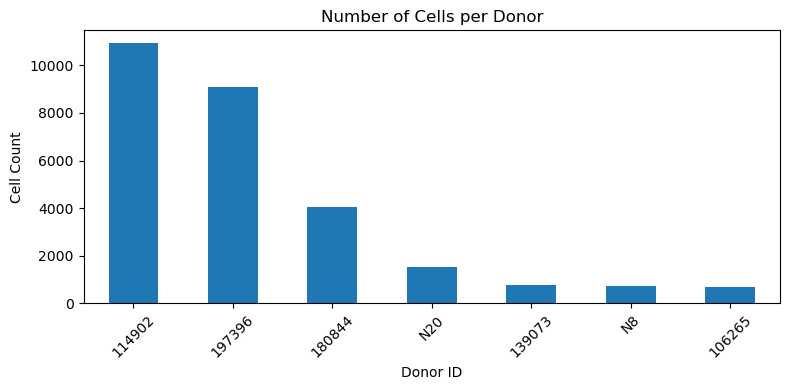

In [118]:
import matplotlib.pyplot as plt
donor_counts = colon_adata.obs['donor_id'].value_counts()
plt.figure(figsize=(8, 4))
donor_counts.plot(kind='bar')
plt.title("Number of Cells per Donor")
plt.xlabel("Donor ID")
plt.ylabel("Cell Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


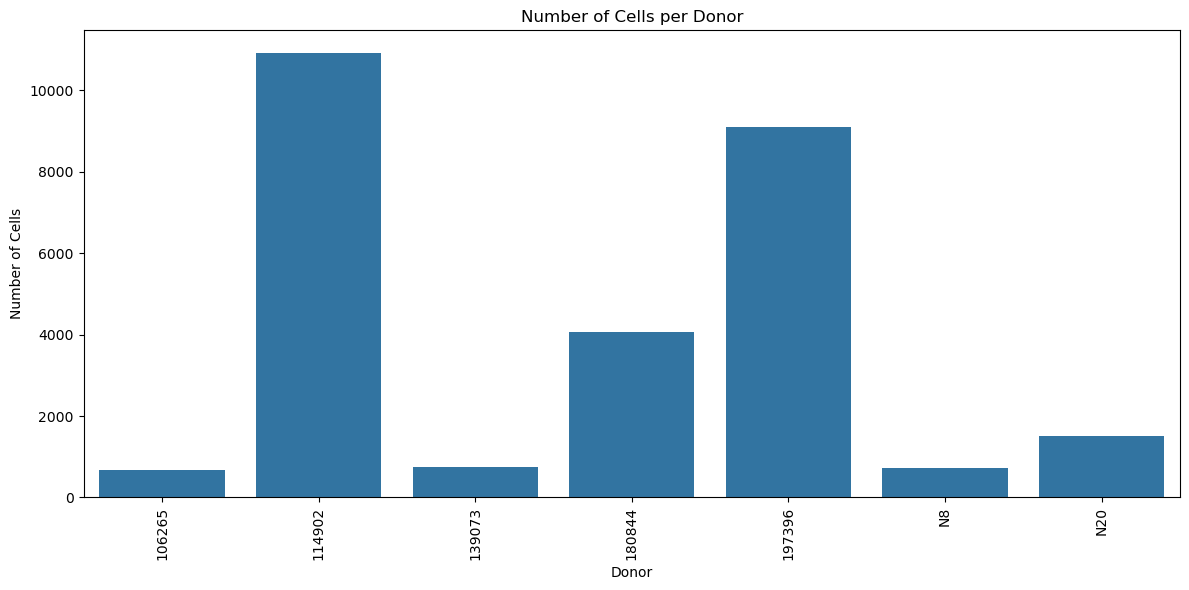

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
donor_counts = colon_adata.obs['donor_id'].value_counts()
plt.figure(figsize=(12, 6))
sns.countplot(data=colon_adata.obs, x='donor_id')
plt.title('Number of Cells per Donor')
plt.xlabel('Donor')
plt.ylabel('Number of Cells')
plt.xticks(rotation=90)
plt.tight_layout()


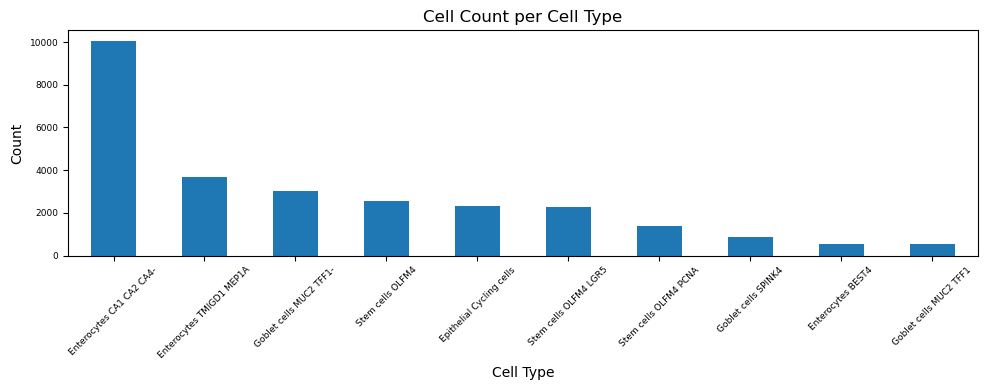

In [128]:
celltype_counts = colon_adata.obs['Celltype'].value_counts()
celltype_sorted = celltype_counts[celltype_counts > 300]
plt.figure(figsize=(10, 4))
celltype_sorted.plot(kind='bar',fontsize=6.5)
plt.title("Cell Count per Cell Type")
plt.xlabel("Cell Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


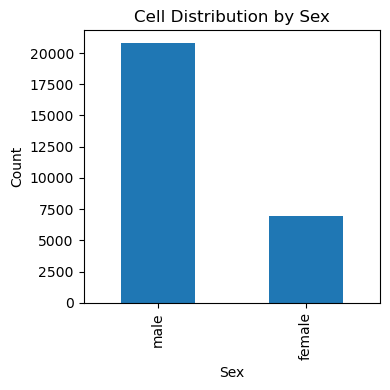

In [30]:
sex_counts = colon_adata.obs['sex'].value_counts()
plt.figure(figsize=(4, 4))
sex_counts.plot(kind='bar')
plt.title("Cell Distribution by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


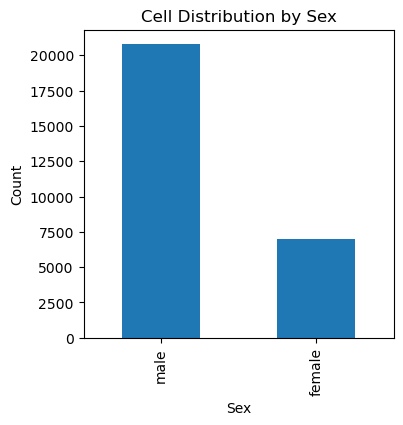

In [130]:
"""Plot and log cell distribution by sex."""
sex_counts = colon_adata.obs['sex'].value_counts()
fig = plt.figure(figsize=(4, 4))
sex_counts.plot(kind='bar')
plt.title('Cell Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.savefig('cell_distribution_by_sex.png')
plt.show()  
plt.close()

In [ ]:
from bokeh.layouts import column
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import layout
import pandas as pd

class PlotsBokeh:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
    
    def plot_combined_distributions(self, colon_adata, save_html=True):
        """Create interactive Bokeh plots for cell types, donor counts, and sex distribution."""
        # Prepare cell type data
        celltype_counts = colon_adata.obs['Celltype'].value_counts()
        celltype_sorted = celltype_counts[celltype_counts > 300]
        celltype_source = ColumnDataSource(data={
            'CellType': celltype_sorted.index.tolist(),
            'Count': celltype_sorted.values.tolist()
        })
        
        # Prepare donor data
        donor_counts = colon_adata.obs['donor_id'].value_counts()
        donor_source = ColumnDataSource(data={
            'DonorID': donor_counts.index.tolist(),
            'CellCount': donor_counts.values.tolist()
        })
        
        # Prepare sex data
        sex_counts = colon_adata.obs['sex'].value_counts()
        sex_source = ColumnDataSource(data={
            'Sex': sex_counts.index.tolist(),
            'Count': sex_counts.values.tolist()
        })
        
        layer_counts = colon_adata.obs['Layer'].value_counts()
        layer_source = ColumnDataSource(data={
            'Layer': layer_counts.index.tolist(),
            'Count': layer_counts.values.tolist()
        })

        
        # Create plots
        p1 = figure(x_range=celltype_sorted.index.tolist(),
                    title="Cell Count per Cell Type",
                    height=300, width=800, toolbar_location=None, tools="")
        p1.vbar(x='CellType', top='Count', source=celltype_source, width=0.8)
        p1.xaxis.major_label_orientation = 1.2
        p1.add_tools(HoverTool(tooltips=[("Cell Type", "@CellType"), ("Count", "@Count")]))
        
        p2 = figure(x_range=donor_counts.index.tolist(),
                    title="Number of Cells per Donor",
                    height=300, width=800, toolbar_location=None, tools="")
        p2.vbar(x='DonorID', top='CellCount', source=donor_source, width=0.8)
        p2.xaxis.major_label_orientation = 1.2
        p2.add_tools(HoverTool(tooltips=[("Donor ID", "@DonorID"), ("Cell Count", "@CellCount")]))
        
        p3 = figure(x_range=sex_counts.index.tolist(),
                    title="Cell Distribution by Sex",
                    height=300, width=400, toolbar_location=None, tools="")
        p3.vbar(x='Sex', top='Count', source=sex_source, width=0.6, color="green")
        p3.add_tools(HoverTool(tooltips=[("Sex", "@Sex"), ("Count", "@Count")]))

        p4 = figure(x_range=layer_counts.index.tolist(),
                    title="Cell Distribution by Layer",
                    height=300, width=400, toolbar_location=None, tools="")
        p4.vbar(x='Layer', top='Count', source=layer_source, width=0.6, color="orange")
        p4.add_tools(HoverTool(tooltips=[("Layer", "@Layer"), ("Count", "@Count")]))
        
        # Arrange the plots (2,2) meaning 2 rows and 2 columns
        layout = layout([[p1, p2], [p3, p4]])
        
        # Save to HTML file if requested
        if save_html:
            output_file("combined_distribution.html")
        
        return layout

# In your Jupyter notebook:
from bokeh.io import output_notebook, show

# Initialize output to notebook
output_notebook()

# Create and display the plot
plot = PlotsBokeh(r"C:\Users\maorb\Classes\Compugen\scGPT-niche\data\base_dataset.h5ad")
plot1 = plot.plot_combined_distributions(colon_adata, save_html=True)
show(plot1)


Loading BokehJS ...

INFO:bokeh.io.state:Session output file 'combined_distribution.html' already exists, will be overwritten.


In [ ]:
# Convert to DataFrame with gene names as columns
import pandas as pd

# Get the first 10 cells and first 20 genes
subset_data = colon_adata.X[:10, :20]
gene_names = colon_adata.var['feature_name'][:20]
cell_ids = colon_adata.obs.index[:10]

# Create a DataFrame
expression_df = pd.DataFrame(
    subset_data.toarray() if hasattr(subset_data, 'toarray') else subset_data,
    index=cell_ids,
    columns=gene_names
)

# Display the DataFrame
print(expression_df)


feature_name                 ENSG00000228463.10  ENSG00000237094.13  \
cell_id                                                               
H197396_N1-GCTTGAAGTCATGCCG                1.58                 0.0   
H197396_N1-AGGGAGTCACCTTGTC                0.00                 0.0   
H197396_N1-CATATTCAGGGAGTAA                0.00                 0.0   
H197396_N1-CGCTTCAAGGCTACGA                0.00                 0.0   
H197396_N1-CGGAGTCGTGAGTGAC                1.85                 0.0   
H197396_N1-GCAGCCAAGGCTCATT                0.00                 0.0   
H197396_N1-TGGCCAGAGCTCCTCT                0.00                 0.0   
H197396_N1-AGAATAGGTGTCAATC                0.00                 0.0   
H197396_N1-GAACCTATCATACGGT                0.00                 0.0   
H197396_N1-ATAGACCAGTACGACG                0.00                 0.0   

feature_name                 ENSG00000228327.6  LINC01409  FAM87B  LINC00115  \
cell_id                                                            

In [24]:
colon_adata.obs["disease"]

cell_id
H197396_N1-GCTTGAAGTCATGCCG           normal
H197396_N1-AGGGAGTCACCTTGTC           normal
H197396_N1-CATATTCAGGGAGTAA           normal
H197396_N1-CGCTTCAAGGCTACGA           normal
H197396_N1-CGGAGTCGTGAGTGAC           normal
                                   ...      
N114902_N-CTGCGGACACAGGCCT     Crohn disease
N114902_N-TTGCGTCTCAAAGACA     Crohn disease
N114902_N-TGCGCAGCAACAACCT     Crohn disease
N114902_N-CTAAGACAGATATACG     Crohn disease
N114902_N-AACTCCCCAGCTGCAC     Crohn disease
Name: disease, Length: 27758, dtype: category
Categories (2, object): ['Crohn disease', 'normal']

In [17]:
#DEscribe the data
colon_adata.obs.describe(include="all")

,biosample_id,n_genes,n_counts,Type,donor_id,Layer,Celltype,organism_ontology_term_id,assay_ontology_term_id,disease_ontology_term_id,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
count,27758,27758.000000,27758.000000,27758,27758,27758,27758,27758,27758,27758,...,27758,27758,27758,27758,27758,27758,27758,27758,27758,27758
unique,18,NaN,NaN,3,7,3,13,1,2,2,...,1,7,2,2,1,2,1,1,6,27758
top,N114902_N,NaN,NaN,Heal,114902,N,Enterocytes CA1 CA2 CA4-,NCBITaxon:9606,EFO:0009899,PATO:0000461,...,tissue,enterocyte,10x 3' v2,normal,Homo sapiens,male,colon,unknown,fourth decade human stage,L0N_ND7A}j
freq,6313,NaN,NaN,16829,10929,25520,10048,27758,25520,16829,...,27758,14288,25520,16829,27758,20778,27758,27758,10929,1
mean,NaN,1024.021543,4036.484509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,1014.794321,6740.244278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,101.000000,247.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,374.000000,734.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,616.000000,1411.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,1223.000000,3782.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import anndata

# Extract your current data as a dense array
dense_X = colon_adata.to_df().values

# Reconstruct the AnnData object with dense X and preserve other attributes as needed
colon_adata = anndata.AnnData(
    X=dense_X,
    obs=colon_adata.obs.copy(),
    var=colon_adata.var.copy(),
    # include additional attributes if necessary, e.g.:
    obsm=colon_adata.obsm.copy() if hasattr(colon_adata, "obsm") else None,
    varm=colon_adata.varm.copy() if hasattr(colon_adata, "varm") else None,
    uns=colon_adata.uns.copy() if hasattr(colon_adata, "uns") else None,
    layers=colon_adata.layers.copy() if hasattr(colon_adata, "layers") else None
)

In [7]:
import scgpt as scg
ref_embed_adata = scg.tasks.embed_data(
   colon_adata,
    model_dir=Path(model_path),
    gene_col='feature_name',
    obs_to_save=list(colon_adata.obs.columns),  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 21003/27289 genes in vocabulary of size 60697.


/homefolder/talb/miniconda3/envs/p310cuda_2025/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
/homefolder/talb/miniconda3/envs/p310cuda_2025/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:258: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

In [8]:
# Optional step to visualize the reference dataset using the embeddings
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)


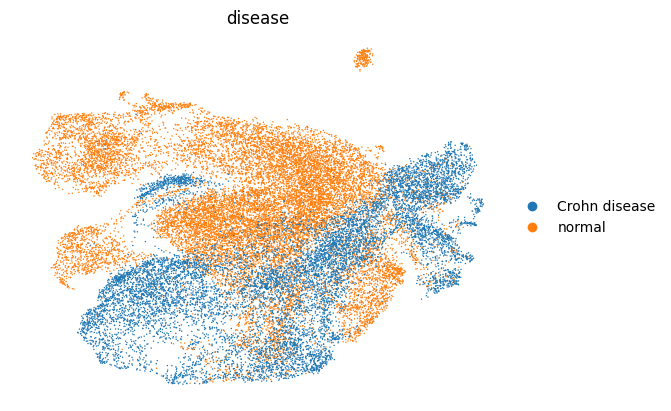

In [9]:
sc.pl.umap(ref_embed_adata, color='disease', frameon=False, wspace=0.4)

In [13]:
ref_embed_adata.X.shape

(27758, 512)

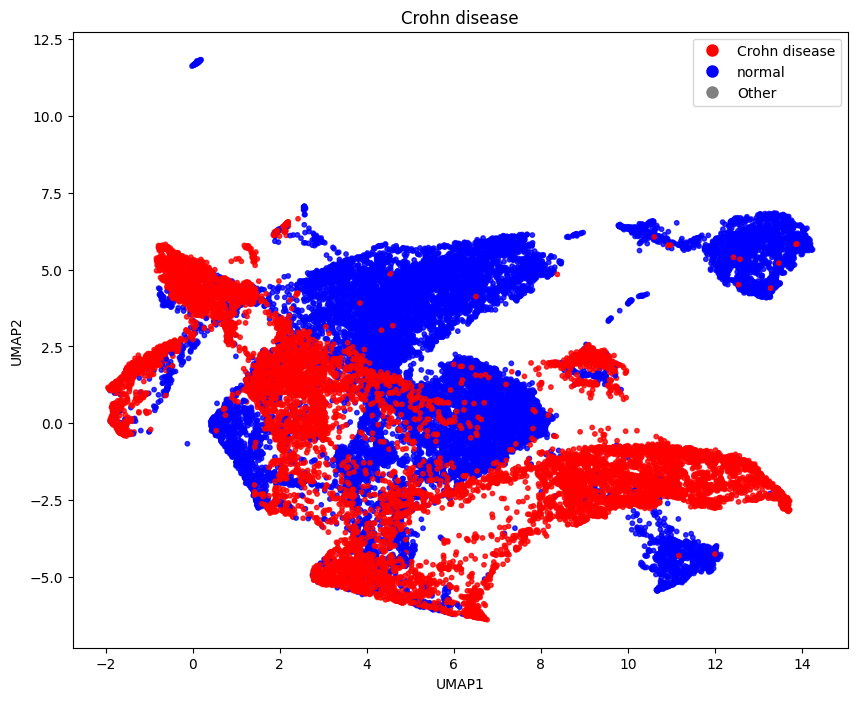

In [15]:
plot_umap("Crohn disease", "normal", colon_adata.obs['disease'].tolist(), ref_embed_adata.X, "Crohn disease")